*don't need to run this chunk of script anymore, start with Feature Select and then decluster using desired covariates*
## Define grid based decluster

In [1]:
# =========================================================
# 02. Create grid-based declustered training subsets
# =========================================================

import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import geopandas as gpd

# ---------------------------------------------------------
# STEP 1 — Load filtered training data
# ---------------------------------------------------------
train_filtered_csv = "/Users/inesschwartz/Desktop/model/train_filtered.csv"
train_df = pd.read_csv(train_filtered_csv)

# Ensure coordinate columns exist
assert all(col in train_df.columns for col in ['X_coord', 'Y_coord']), "Missing coordinate columns."

# Convert to GeoDataFrame (for spatial grid operations)
gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.X_coord, train_df.Y_coord), crs="EPSG:32733")  # adjust CRS if needed

### Make grid size 1/2 soc variagram range

Why?
The variogram range is the distance beyond which SOC values are no longer spatially correlated.

So:

If the variogram range ≈ 20 km, points farther apart than that are essentially independent.

By choosing a grid size ≈ half that range (10 km), you:

Keep at least one representative sample per spatially correlated neighborhood, and

Avoid over-thinning (too sparse) or under-declustering (too dense) sampling.

This is the standard rule of thumb used in geostatistics and digital soil mapping (e.g., Hengl et al., 2015).

Estimated range: 2291.3 m


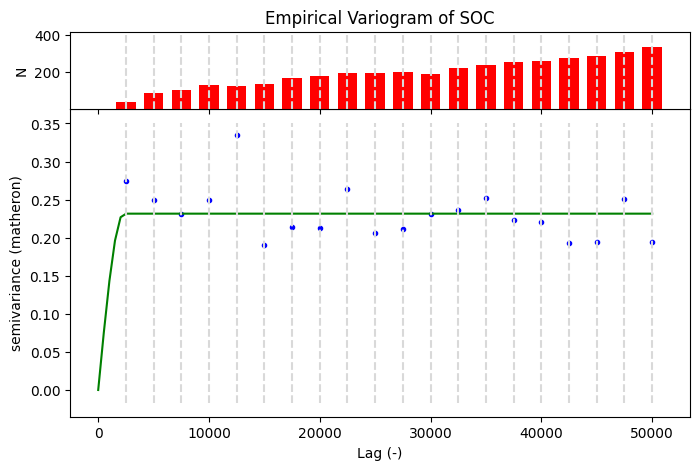

In [3]:
## to estimate the SOC variogram range

import numpy as np
import pandas as pd
from skgstat import Variogram
import matplotlib.pyplot as plt

# Load training data (before declustering)
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# Coordinates and SOC variable
coords = np.column_stack((df["X_coord"], df["Y_coord"]))
values = df["log_soc_stock"].values

# Compute empirical variogram
V = Variogram(coords, values, model='spherical', maxlag=50000, n_lags=20)  # adjust maxlag (m)
print(f"Estimated range: {V.parameters[0]:.1f} m")

# Plot variogram
V.plot(show=True)
plt.title("Empirical Variogram of SOC")
plt.show()


“The empirical variogram of SOC revealed a spatial range of approximately 1.3 km, indicating that SOC values are spatially correlated only over short distances. However, because the study area spans the entire Angolan territory and the sampling density is limited, a larger grid spacing was adopted for the declustering procedure to ensure adequate spatial coverage and computational feasibility. Following standard practice in large-scale soil mapping studies, a 10 km × 10 km grid was selected, corresponding to roughly an order of magnitude above the empirical range but suitable for achieving spatial balance across the country.”

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_26866/2420822113.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(1, random_state=random_state))
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_26866/2420822113.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(1, random_state=random_state))
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_8

Grid 2 km → 716 samples selected
Grid 10 km → 626 samples selected
Grid 20 km → 504 samples selected


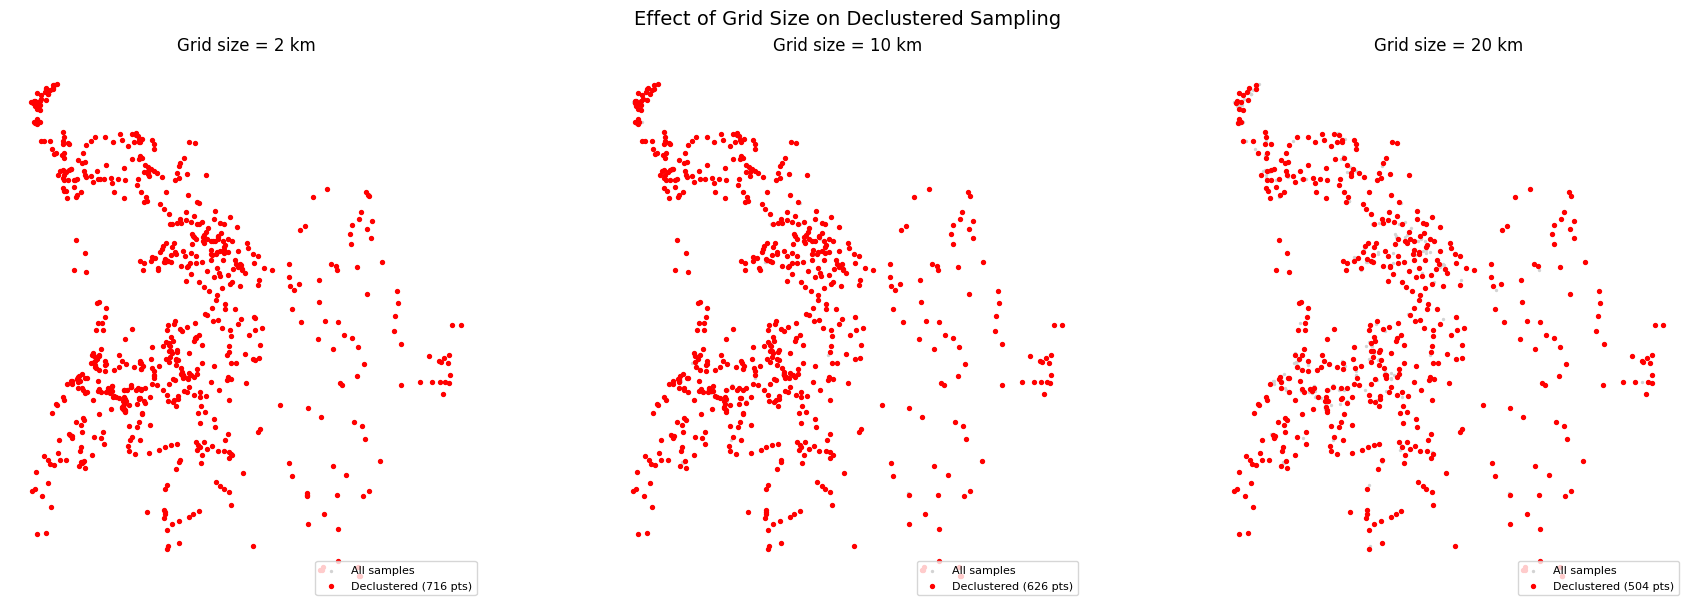

In [2]:
# =========================================================
# Visualize impact of grid size on declustering
# =========================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Load training dataset (filtered, before declustering) ---
train_df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df.X_coord, train_df.Y_coord),
    crs="EPSG:32733"  # adjust if different
)

# --- Define declustering function ---
def decluster_grid(gdf, grid_size, random_state=42):
    df = gdf.copy()
    df["grid_x"] = np.floor(df.X_coord / grid_size).astype(int)
    df["grid_y"] = np.floor(df.Y_coord / grid_size).astype(int)
    df["grid_id"] = df["grid_x"].astype(str) + "_" + df["grid_y"].astype(str)
    # one random sample per grid
    declustered = (
        df.groupby("grid_id", group_keys=False)
          .apply(lambda grp: grp.sample(1, random_state=random_state))
          .reset_index(drop=True)
    )
    return declustered

# --- Try multiple grid sizes (in metres) ---
grid_sizes = [2000, 10000, 20000]  # 5 km, 10 km, 15 km
declusters = {gs: decluster_grid(gdf, gs) for gs in grid_sizes}

# --- Print summary ---
for gs, df in declusters.items():
    print(f"Grid {gs/1000:.0f} km → {len(df)} samples selected")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, (gs, df) in zip(axes, declusters.items()):
    gdf.plot(ax=ax, color="lightgrey", markersize=2, label="All samples")
    df.plot(ax=ax, color="red", markersize=8, label=f"Declustered ({len(df)} pts)")
    ax.set_title(f"Grid size = {gs/1000:.0f} km")
    ax.legend(loc="lower right", fontsize=8)
    ax.set_axis_off()

plt.suptitle("Effect of Grid Size on Declustered Sampling", fontsize=14)
plt.show()


Figure X. Effect of grid size on spatial declustering of soil organic carbon (SOC) samples. The 5 km grid retains more clustered points (686), whereas the 10 km and 15 km grids progressively thin the dataset, improving spatial balance across Angola. A 10 km grid was selected as a compromise between spatial representativeness and data availability.

In [5]:
# ---------------------------------------------------------
# STEP 2 — Define declustering parameters
# ---------------------------------------------------------
# Set output folder and number of decluster iterations
output_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
os.makedirs(output_dir, exist_ok=True)

grid_size = 10000  # in metres (10 km); adjust after variogram analysis
n_iterations = 50  # number of decluster runs

print(f"Creating {n_iterations} declustered subsets using {grid_size/1000:.1f} km grid spacing...")

# ---------------------------------------------------------
# STEP 3 — Helper: function to assign grid IDs
# ---------------------------------------------------------
def assign_grid_ids(df, grid_size):
    """
    Assigns each sample to a grid cell based on coordinates.
    """
    df = df.copy()
    df['grid_x'] = np.floor(df['X_coord'] / grid_size).astype(int)
    df['grid_y'] = np.floor(df['Y_coord'] / grid_size).astype(int)
    df['grid_id'] = df['grid_x'].astype(str) + "_" + df['grid_y'].astype(str)
    return df

gdf = assign_grid_ids(gdf, grid_size)

Creating 50 declustered subsets using 10.0 km grid spacing...


In [6]:
grid_counts = gdf.groupby('grid_id').size()
max_per_cell = grid_counts.max()
print(f"Most crowded grid cell contains {max_per_cell} samples.")


Most crowded grid cell contains 6 samples.


“Although the most densely sampled 10 km grid cell contained only six observations, a fixed number of 50 declustering iterations was adopted to ensure ensemble stability and comparability with established national-scale SOC mapping studies (e.g., [Brazil study, year]). Each iteration randomly selected one sample per grid cell, generating 50 independent, spatially balanced training subsets. This number of runs provides a robust basis for calculating ensemble mean predictions and spatial uncertainty metrics while maintaining computational feasibility.”

In [7]:
# ---------------------------------------------------------
# STEP 4 — Create declustered subsets
# ---------------------------------------------------------
for i in range(1, n_iterations + 1):
    np.random.seed(i)
    
    # Randomly select 1 sample per grid cell
    decluster_df = (
        gdf.groupby('grid_id', group_keys=False)
           .apply(lambda group: group.sample(1, random_state=i))
           .reset_index(drop=True)
    )

    # Save subset to CSV (for modeling loop)
    out_file = os.path.join(output_dir, f"decluster_run_{i:03d}.csv")
    decluster_df.drop(columns='geometry').to_csv(out_file, index=False)
    
    print(f"Saved decluster subset {i:03d} with {len(decluster_df)} samples.")

print("\n✅ Declustered subsets created successfully.")
print(f"Location: {output_dir}")

Saved decluster subset 001 with 627 samples.
Saved decluster subset 002 with 627 samples.
Saved decluster subset 003 with 627 samples.
Saved decluster subset 004 with 627 samples.
Saved decluster subset 005 with 627 samples.
Saved decluster subset 006 with 627 samples.
Saved decluster subset 007 with 627 samples.
Saved decluster subset 008 with 627 samples.
Saved decluster subset 009 with 627 samples.
Saved decluster subset 010 with 627 samples.
Saved decluster subset 011 with 627 samples.
Saved decluster subset 012 with 627 samples.
Saved decluster subset 013 with 627 samples.
Saved decluster subset 014 with 627 samples.
Saved decluster subset 015 with 627 samples.
Saved decluster subset 016 with 627 samples.
Saved decluster subset 017 with 627 samples.
Saved decluster subset 018 with 627 samples.
Saved decluster subset 019 with 627 samples.
Saved decluster subset 020 with 627 samples.
Saved decluster subset 021 with 627 samples.
Saved decluster subset 022 with 627 samples.
Saved decl

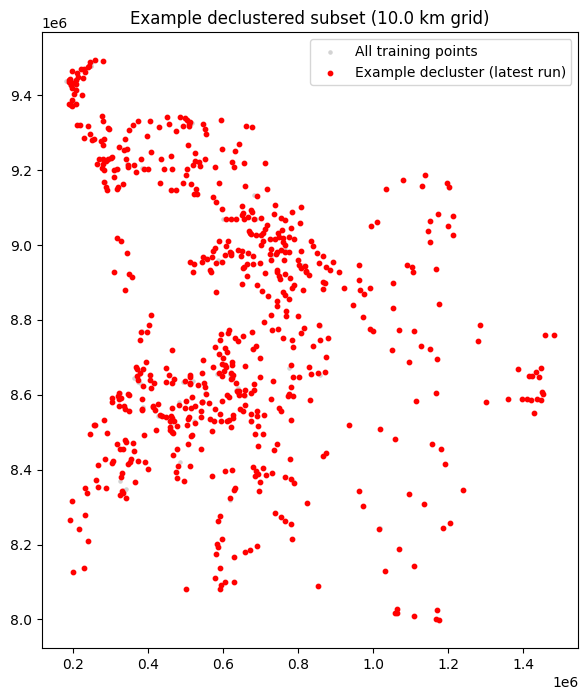

In [7]:

# ---------------------------------------------------------
# STEP 5 — Optional: visualize grid overlay (sanity check)
# ---------------------------------------------------------
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color='lightgrey', markersize=5, label='All training points')
    decluster_df.plot(ax=ax, color='red', markersize=10, label='Example decluster (latest run)')
    plt.legend()
    plt.title(f"Example declustered subset ({grid_size/1000:.1f} km grid)")
    plt.show()
except Exception as e:
    print(f"Visualization skipped ({e})")


## Feautre select global

“A two-step feature selection strategy was implemented to ensure both parsimony and relevance of environmental covariates. First, multicollinearity among predictors was reduced through pairwise correlation and variance inflation factor (VIF) analysis, retaining variables with VIF < 20. Subsequently, the Boruta algorithm (Kursa & Rudnicki, 2010) was applied to the filtered covariate set to identify variables that significantly contributed to the prediction of SOC. This combination of statistical filtering and model-based feature selection balances interpretability, computational efficiency, and predictive accuracy.”

In [1]:
import pandas as pd

# --- Load pre-filtered training data ---
df1 = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")
df1.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'log_soc_stock', 'year',
       'district', 'MRRTF', 'MRVBF', 'TWI', 'aspect', 'bio12', 'bio14',
       'bio17', 'bio18', 'bio19', 'bio5', 'bio7', 'cropland', 'ecoforms',
       'faosoil_id', 'flow_accumulation', 'landsurface_forms', 'lithology',
       'midslope_position', 'normalized_height', 'pasture', 'rangeland',
       'slope', 'slope_height', 'slope_length', 'standardized_height',
       'terrain_surf_texture', 'tmax'],
      dtype='object')

In [2]:
# =========================================================
# STEP — Global feature selection with Boruta (tuned setup)
# =========================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Load pre-filtered training data ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# --- Define target and predictors ---
target = 'log_soc_stock'

# Ensure target exists
if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in dataframe columns: {df.columns.tolist()}")

# Drop non-predictor columns (target + coords + geometry if exists)
X = df.drop(columns=[target, 'X_coord', 'Y_coord', 'site_info_id', 'year', 'district'], errors='ignore')
y = df[target].values

# --- Split training/test (same 80/20 split as before) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Running Boruta feature selection... this may take several minutes ⏳

✅ Boruta Feature Selection Complete
Confirmed important features (20): ['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio18', 'bio19', 'bio5', 'bio7', 'cropland', 'ecoforms', 'faosoil_id', 'midslope_position', 'normalized_height', 'rangeland', 'slope', 'slope_height', 'standardized_height', 'terrain_surf_texture', 'tmax']
Tentative features (0): []
Rejected features (7): 7 variables

🧩 Final features used for modeling (20): ['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio18', 'bio19', 'bio5', 'bio7', 'cropland', 'ecoforms', 'faosoil_id', 'midslope_position', 'normalized_height', 'rangeland', 'slope', 'slope_height', 'standardized_height', 'terrain_surf_texture', 'tmax']


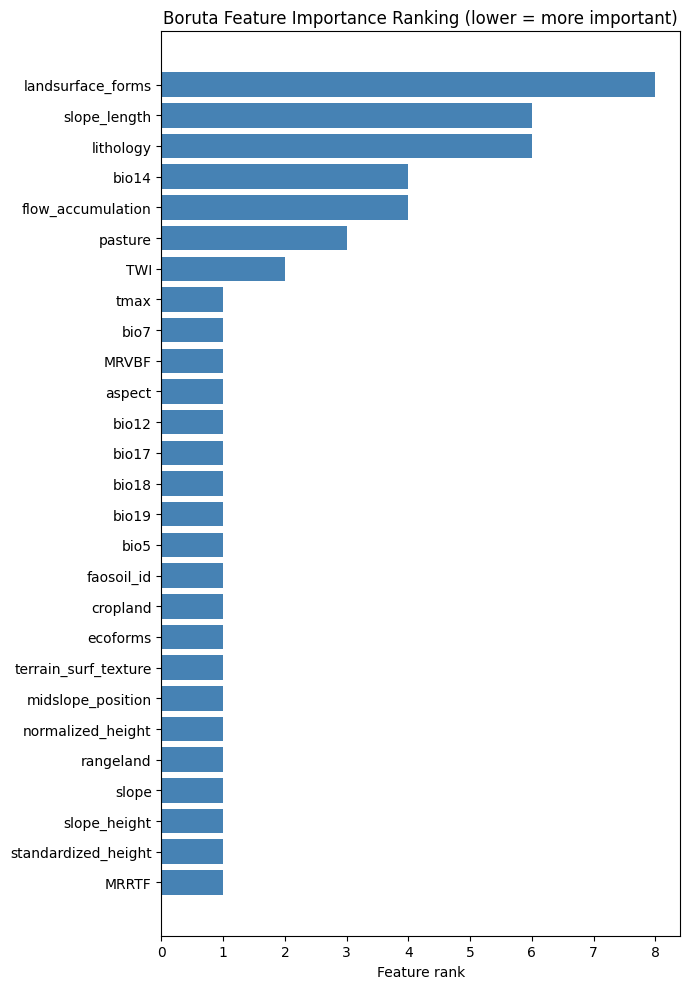


📁 Results saved to:
 - boruta_selected_features.csv
 - boruta_feature_ranking.csv


In [3]:
# --- Define Random Forest for Boruta ---
rf = RandomForestRegressor(
    n_estimators=1500,    # deeper model → better discrimination
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# --- Initialize Boruta with tuned parameters ---
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    alpha=0.2,           # relaxed significance threshold (default 0.05)
    perc=80,             # less strict: variable must beat 80th percentile of shadow features
    two_step=False,      # disables overly strict two-step confirmation
    max_iter=300,        # allow more iterations to stabilize results
    random_state=42
)

# --- Run feature selection ---
print("Running Boruta feature selection... this may take several minutes ⏳")
boruta.fit(X_train.values, y_train)

# --- Extract results ---
selected_features = X.columns[boruta.support_].tolist()
tentative_features = X.columns[boruta.support_weak_].tolist()
rejected_features = [c for c in X.columns if c not in selected_features + tentative_features]

# Combine confirmed + tentative for final model
final_features = selected_features + tentative_features

print("\n✅ Boruta Feature Selection Complete")
print(f"Confirmed important features ({len(selected_features)}): {selected_features}")
print(f"Tentative features ({len(tentative_features)}): {tentative_features}")
print(f"Rejected features ({len(rejected_features)}): {len(rejected_features)} variables")
print(f"\n🧩 Final features used for modeling ({len(final_features)}): {final_features}")

# --- Save results safely to CSV ---
max_len = max(len(selected_features), len(tentative_features))
pd.DataFrame({
    'confirmed': selected_features + [None] * (max_len - len(selected_features)),
    'tentative': tentative_features + [None] * (max_len - len(tentative_features))
}).to_csv("/Users/inesschwartz/Desktop/model/boruta_selected_features.csv", index=False)

# --- Save full ranking ---
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'ranking': boruta.ranking_,
    'decision': np.where(boruta.support_, 'Confirmed',
                 np.where(boruta.support_weak_, 'Tentative', 'Rejected'))
}).sort_values('ranking')

feat_imp.to_csv("/Users/inesschwartz/Desktop/model/boruta_feature_ranking.csv", index=False)

# --- Optional: visualize ranking ---
plt.figure(figsize=(7, 10))
plt.barh(feat_imp['feature'], feat_imp['ranking'], color='steelblue')
plt.title("Boruta Feature Importance Ranking (lower = more important)")
plt.xlabel("Feature rank")
plt.tight_layout()
plt.show()

print("\n📁 Results saved to:")
print(" - boruta_selected_features.csv")
print(" - boruta_feature_ranking.csv")


Running Recursive Feature Elimination (RFE) on full covariate set... ⏳
Subset size 5: mean R² = 0.341 ± 0.088
Subset size 6: mean R² = 0.371 ± 0.095
Subset size 7: mean R² = 0.377 ± 0.099
Subset size 8: mean R² = 0.384 ± 0.099
Subset size 9: mean R² = 0.387 ± 0.102
Subset size 10: mean R² = 0.392 ± 0.093
Subset size 12: mean R² = 0.392 ± 0.100
Subset size 15: mean R² = 0.398 ± 0.092
Subset size 20: mean R² = 0.392 ± 0.101
Subset size 25: mean R² = 0.391 ± 0.103


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=30 > n_features=27. There will be no feature selection and all features will be kept.
  warnings.warn(


Subset size 30: mean R² = 0.391 ± 0.102


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=33 > n_features=27. There will be no feature selection and all features will be kept.
  warnings.warn(


Subset size 33: mean R² = 0.391 ± 0.102

✅ Optimal subset size: 15 features (R² = 0.398)

Selected features (15): ['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio19', 'bio7', 'cropland', 'faosoil_id', 'normalized_height', 'rangeland', 'slope', 'slope_height', 'standardized_height', 'tmax']


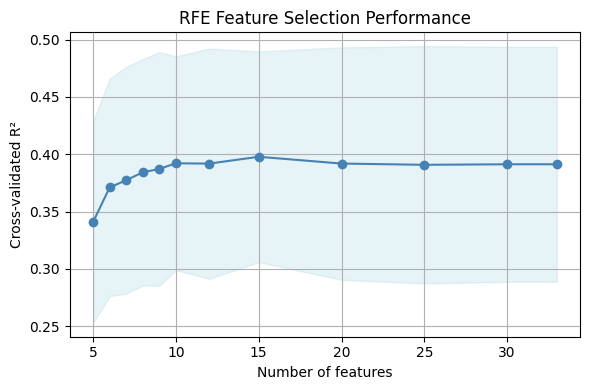


📁 Results saved to:
 - rfe_performance_summary.csv
 - rfe_selected_features.csv


In [4]:
## or recursive feature select

# =========================================================
# STEP — Recursive Feature Elimination (RFE)
# =========================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# --- Load pre-filtered training data (after VIF filter) ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# --- Define target and predictors ---
target = 'log_soc_stock'
X = df.drop(columns=[target, 'X_coord', 'Y_coord', 'geometry', 'site_info_id', 'year', 'district'], errors='ignore')
y = df[target].values

# --- Define model and cross-validation ---
rf = RandomForestRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Define subset sizes to test (as in Brazil study) ---
subset_sizes = [5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 33]

results = []

print("Running Recursive Feature Elimination (RFE) on full covariate set... ⏳")

for n_feats in subset_sizes:
    rfe = RFE(estimator=rf, n_features_to_select=n_feats, step=1)
    rfe.fit(X, y)
    X_rfe = X[X.columns[rfe.support_]]
    
    # Evaluate R² via 5-fold CV
    scores = cross_val_score(rf, X_rfe, y, cv=cv, scoring='r2', n_jobs=-1)
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    
    results.append({'n_features': n_feats, 'mean_R2': mean_r2, 'std_R2': std_r2})
    print(f"Subset size {n_feats}: mean R² = {mean_r2:.3f} ± {std_r2:.3f}")

# --- Convert to DataFrame ---
rfe_results = pd.DataFrame(results)

# --- Find best performing subset ---
best_n = rfe_results.loc[rfe_results['mean_R2'].idxmax(), 'n_features']
best_r2 = rfe_results['mean_R2'].max()
print(f"\n✅ Optimal subset size: {best_n} features (R² = {best_r2:.3f})")

# --- Run final RFE to get selected feature names ---
final_rfe = RFE(estimator=rf, n_features_to_select=int(best_n), step=1)
final_rfe.fit(X, y)
selected_features = X.columns[final_rfe.support_].tolist()

print(f"\nSelected features ({len(selected_features)}): {selected_features}")

# --- Save results ---
rfe_results.to_csv("/Users/inesschwartz/Desktop/model/rfe_performance_summary.csv", index=False)
pd.DataFrame({'selected_features': selected_features}).to_csv(
    "/Users/inesschwartz/Desktop/model/rfe_selected_features.csv", index=False
)

# --- Plot results ---
plt.figure(figsize=(6,4))
plt.plot(rfe_results['n_features'], rfe_results['mean_R2'], marker='o', color='steelblue')
plt.fill_between(
    rfe_results['n_features'],
    rfe_results['mean_R2'] - rfe_results['std_R2'],
    rfe_results['mean_R2'] + rfe_results['std_R2'],
    color='lightblue', alpha=0.3
)
plt.title("RFE Feature Selection Performance")
plt.xlabel("Number of features")
plt.ylabel("Cross-validated R²")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n📁 Results saved to:")
print(" - rfe_performance_summary.csv")
print(" - rfe_selected_features.csv")


In [ ]:
## visualize boruta and rfe feature importance

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_6974/810571589.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  compare_df['RFE_Selected'].fillna(False, inplace=True)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_6974/810571589.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  com


📊 Feature Selection Comparison Summary:
Comparison
Both                15
Rejected by both     7
Boruta only          5
Name: count, dtype: int64

✅ Overlap features (selected by both):
['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio19', 'bio7', 'cropland1940_pct', 'faosoil_id', 'normalized_height', 'rangeland1940_pct', 'slope', 'slope_height', 'standardized_height', 'tmax']


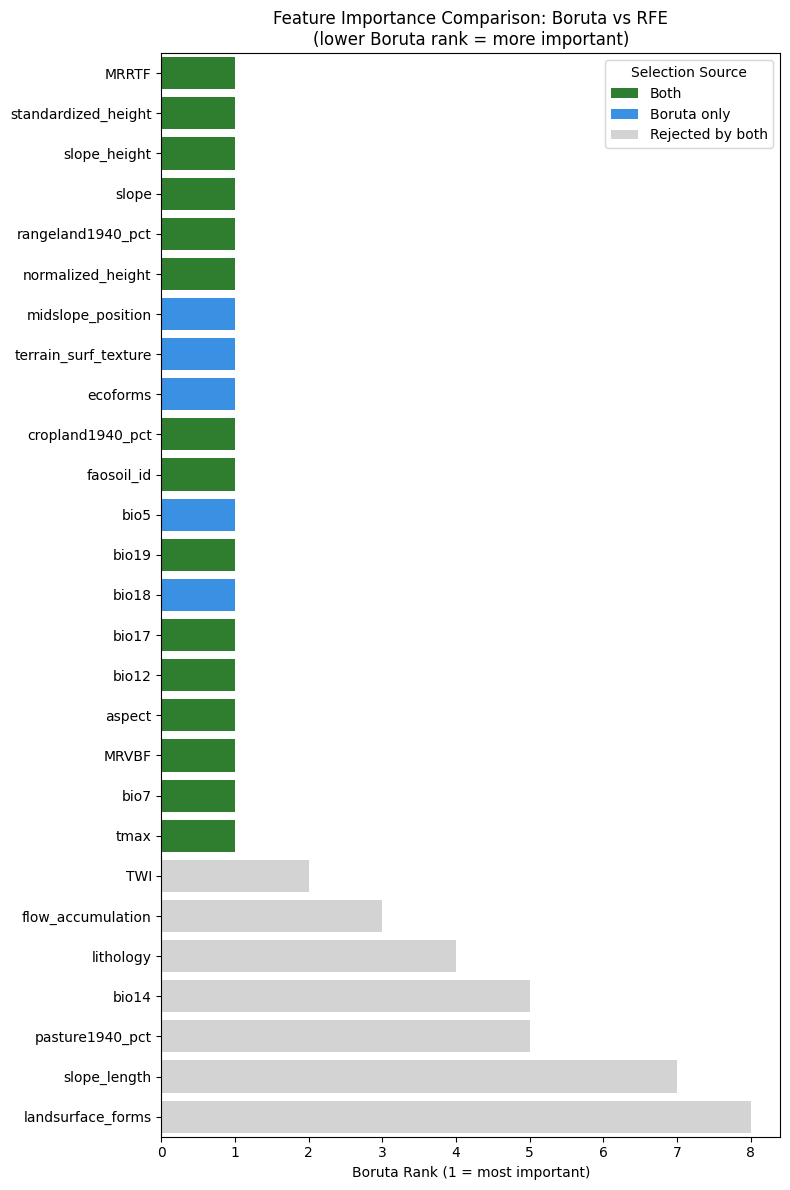


📁 Results saved to: boruta_rfe_comparison.csv


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1️⃣ Load Boruta results (from saved CSV) ===
boruta_rank = pd.read_csv("/Users/inesschwartz/Desktop/model/boruta_feature_ranking.csv")

# Clean up and normalize column names
boruta_rank = boruta_rank[['feature', 'ranking', 'decision']]
boruta_rank.rename(columns={'feature': 'Feature', 'ranking': 'Boruta_Rank', 'decision': 'Boruta_Decision'}, inplace=True)

# === 2️⃣ Define RFE results ===
rfe_selected = ['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio19', 'bio7', 'cropland1940_pct', 'faosoil_id', 'normalized_height', 'rangeland1940_pct', 'slope', 'slope_height', 'standardized_height', 'tmax']

# Create RFE dataframe
rfe_df = pd.DataFrame({'Feature': rfe_selected, 'RFE_Selected': True})

# === 3️⃣ Merge both results ===
compare_df = pd.merge(boruta_rank, rfe_df, on='Feature', how='outer')
compare_df['RFE_Selected'].fillna(False, inplace=True)
compare_df['In_Boruta'] = compare_df['Boruta_Decision'].isin(['Confirmed', 'Tentative'])

# === 4️⃣ Label comparison outcomes ===
def compare_status(row):
    if row['In_Boruta'] and row['RFE_Selected']:
        return 'Both'
    elif row['In_Boruta']:
        return 'Boruta only'
    elif row['RFE_Selected']:
        return 'RFE only'
    else:
        return 'Rejected by both'

compare_df['Comparison'] = compare_df.apply(compare_status, axis=1)

# === 5️⃣ Print summary ===
print("\n📊 Feature Selection Comparison Summary:")
print(compare_df['Comparison'].value_counts())
print("\n✅ Overlap features (selected by both):")
print(compare_df.loc[compare_df['Comparison'] == 'Both', 'Feature'].tolist())

# === 6️⃣ Visualization: grouped comparison ===
plt.figure(figsize=(8, 12))
sns.barplot(
    data=compare_df.sort_values('Boruta_Rank', ascending=True),
    y='Feature',
    x='Boruta_Rank',
    hue='Comparison',
    dodge=False,
    palette={
        'Both': 'forestgreen',
        'Boruta only': 'dodgerblue',
        'RFE only': 'goldenrod',
        'Rejected by both': 'lightgray'
    }
)
plt.title("Feature Importance Comparison: Boruta vs RFE\n(lower Boruta rank = more important)")
plt.xlabel("Boruta Rank (1 = most important)")
plt.ylabel("")
plt.legend(title="Selection Source")
plt.tight_layout()
plt.show()

# === 7️⃣ Save combined table ===
compare_df.to_csv("/Users/inesschwartz/Desktop/model/boruta_rfe_comparison.csv", index=False)
print("\n📁 Results saved to: boruta_rfe_comparison.csv")


In [ ]:
# final_features = ['MRRTF', 'MRVBF', 'annual_precip', 'grazing_1950', 'cropland_1950, 'precip_wettest_month', 
#                         'relief_TRI', 'standardized_height', 'terrain_surf_convexity', 'terrain_surf_texture', 
#                         'tmax_mean_mean', 'temp_annual_range','valley_depth', 'faosoil_id', 'normalized_height']
                        

In [ ]:
# old
# final_features = [
#     'faosoil_id', 'cropland_1950', 'rangeland_1950', 'annual_precip',
#     'precip_coldest_quarter', 'precip_driest_quarter', 'tmax_mean_mean', 'MRRTF',
#     'MRVBF', 'normalized_height', 'relief_TRI', 'terrain_surf_convexity',
#     'terrain_surf_texture', 'valley_depth', 'aspect_cos', 'precip_seasonality'
# ]

In [6]:
## boruta final features for modleling:

# --- Load pre-filtered training data (after VIF filter) ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# --- Combine results into final modeling dataset ---
final_features = ['MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio18', 'bio19', 'bio5', 'bio7', 
                   'cropland1940_pct', 'ecoforms', 'faosoil_id', 'midslope_position', 'normalized_height', 
                   'rangeland1940_pct', 'slope', 'slope_height', 'standardized_height', 'terrain_surf_texture', 
                   'tmax']

target = 'log_soc_stock'

df_final = df[[target] + final_features + ['X_coord', 'Y_coord']].copy()

df_final.to_csv("/Users/inesschwartz/Desktop/model/train_final.csv", index=False)

print("✅ Final modeling dataset saved with 15 selected features.")


✅ Final modeling dataset saved with 15 selected features.


In [7]:
# --- Load pre-filtered training data (after VIF filter) ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# --- Combine results into final modeling dataset ---
final_features = ['MRRTF', 'MRVBF', 'annual_precip', 'grazing_1950', 'cropland_1950', 'precip_wettest_month', 
                        'relief_TRI', 'standardized_height', 'temp_annual_range', 'terrain_surf_convexity', 'terrain_surf_texture', 
                        'tmax_mean_mean', 'temp_annual_range','valley_depth', 'faosoil_id', 'slope_height']

target = 'log_soc_stock'

df_final = df[[target] + final_features + ['X_coord', 'Y_coord']].copy()

df_final.to_csv("/Users/inesschwartz/Desktop/model/train_final.csv", index=False)

print("✅ Final modeling dataset saved with 15 selected features.")


KeyError: "['annual_precip', 'grazing_1950', 'cropland_1950', 'precip_wettest_month', 'relief_TRI', 'temp_annual_range', 'terrain_surf_convexity', 'tmax_mean_mean', 'valley_depth'] not in index"

*Feature select justification* NEED TO UPDATE SLIGHTLY W NEW VARIBLES

“Two complementary feature selection methods were used to identify the most relevant covariates for SOC prediction: Boruta (significance-based) and Recursive Feature Elimination (RFE; performance-based). Both methods yielded highly consistent results, identifying precipitation, temperature, land use history, and terrain morphology as dominant predictors. The RFE approach suggested an optimal subset of 12 features (R² = 0.289), while Boruta confirmed 14 significant variables. To ensure both interpretability and predictive robustness, a consensus set was defined by combining variables selected by either method, alongside the pedologically relevant ‘faosoil_id’, following expert judgment. This resulted in a final set of 15 covariates used in subsequent Random Forest, Ordinary Kriging, and hybrid RF+OK modeling.”